## Imports and Setups

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import json, time

from gan import preprocessing, tadgan, postprocessing, utils

In [2]:
# set constants and hyperparameters

DATASET = 'data/output.csv'

# preprocessing
RESAMPLE_FREQ = 'H'  
WINDOW_SIZE = 100

# reconstruction model (TadGAN)
LATENT_DIM = 20
ENCODER_PARAMS = {'LSTM_units': 100}
GENERATOR_PARAMS = {'LSTM_units': 64, 'LSTM_dropout': 0.2}
LEARNING_RATE = 0.0001
EPOCHS = 50

# postprocessing
RECON_SCORE_PARAMS = {'dtw_window': 10}
ANOMALOUS_SEQ_PARAMS = {'sd_threshold': 4.0, 'pad': 50}

## Load Time Series Data

In [3]:
# import time series

x = pd.read_csv(DATASET)

x['time'] = pd.to_datetime(x['time'],format="%d-%m-%Y %H:%M:%S")
x.set_index('time', inplace=True)
x.index = pd.to_datetime(x.index)
x.sort_index(inplace=True)

print(f'Number of time stamps: {x.size}')
print(f'First 3 time stamps: {x.index[0]}, {x.index[1]}, {x.index[2]}')
print(f'Last 3 time stamps: {x.index[-3]}, {x.index[-2]}, {x.index[-1]}')

x.describe()

Number of time stamps: 216546
First 3 time stamps: 2020-07-01 10:11:35, 2020-07-02 15:51:53, 2020-07-02 15:54:35
Last 3 time stamps: 2023-09-07 12:48:25, 2023-09-07 13:09:13, 2023-09-07 13:12:28


,temperature
count,2.165460e+05
mean,-1.045808e+03
std,3.531911e+05
min,-1.162173e+08
25%,2.540000e+01
50%,2.810000e+01
75%,2.960000e+01
max,4.430000e+01


In [4]:
temp = x['temperature']
temp = temp[temp>=18]
temp = temp.resample('30min').mean()
print(temp)

train = temp[(temp.index.year<2022) | ((temp.index.year==2022)&(temp.index.month<9))]
test = temp[(temp.index.year>2022) | ((temp.index.year==2022)&(temp.index.month>=9))]

train.head()

time
2020-07-02 15:30:00    24.366667
2020-07-02 16:00:00          NaN
2020-07-02 16:30:00          NaN
2020-07-02 17:00:00          NaN
2020-07-02 17:30:00          NaN
                         ...    
2023-09-07 11:00:00    36.650000
2023-09-07 11:30:00    35.400000
2023-09-07 12:00:00    37.666667
2023-09-07 12:30:00    36.150000
2023-09-07 13:00:00    36.600000
Freq: 30T, Name: temperature, Length: 55772, dtype: float64


time
2020-07-02 15:30:00    24.366667
2020-07-02 16:00:00          NaN
2020-07-02 16:30:00          NaN
2020-07-02 17:00:00          NaN
2020-07-02 17:30:00          NaN
Freq: 30T, Name: temperature, dtype: float64

## Prepare Training Data

To prepare training data for the reconstruction model, we apply to the raw time series a pipeline of preprocessing steps. The main steps are, in order:
- resample the time series at a specified frequency
- rescale values to between 0 and 1
- collect (overlapping) segments of the time series over rolling windows of a fixed specified length (which will be the input dimension of the reconstruction model)



In [9]:
# apply preprocessing pipeline

train, t, x_win, t_win = preprocessing.apply_pipeline(train, freq=RESAMPLE_FREQ, window_size=WINDOW_SIZE)

In [10]:
print(f'Number of rolling windows: {x_win.shape[0]}')
print(f'Start times of the first 3 windows: {t_win[:3]}')

Number of rolling windows: 18870
Start times of the first 3 windows: ['2020-07-02T15:00:00.000000000' '2020-07-02T16:00:00.000000000'
 '2020-07-02T17:00:00.000000000']


## Train Reconstruction Model (TadGAN)

[TadGAN](https://arxiv.org/abs/2009.07769v3) is a time series reconstruction model developed by researchers at MIT. The model aims to **closely reconstruct only the non-anomalous parts of time series**, via the interactions of the following components:
- The **encoder** is trained to embed a given collection of time series into normally distributed vectors in a latent space.
- The **generator** is trained to generate time series that resemble the given collection using random vectors in the latent space. 
- The **input space critic** is trained to differentiate between real time series from the given collection and outputs of the generator.
- The **latent space critic** is trained to differentiate between randomly sampled vectors in the latent space and outputs of the encoder.
- In particular, the adversarial goals of the encoder-generator pair and the critics help improve one another (much like other GAN models). 

Here we instantiate a TadGAN model and fit it to the prepared training data. For faster training, in our re-implementation in TensorFlow 2, we have specified the LSTM layers in a way that meets the [requirements of the cuDNN kernel](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM).




In [11]:
# instantiate and configure a TadGAN model

params = {
    'input_dim': WINDOW_SIZE,
    'latent_dim': LATENT_DIM,
    'learning_rate': LEARNING_RATE,
    'encoder': ENCODER_PARAMS,
    'generator': GENERATOR_PARAMS
}

model = tadgan.TadGAN(**params)

In [12]:
# train the model

t0 = time.time()
model.fit(x_win, epochs=EPOCHS)
t1 = time.time()

Epoch 1/50 (227.1 secs)
  Critic X Loss: 0.375742 [-5.04899989  4.1873242   0.12374175]
  Critic Z Loss: -2.660010 [ 0.34113296 -4.87113635  0.18699933]
  Encoder Generator Loss: 4.759089 [-4.16661338  5.80080182  0.31249001]
Epoch 2/50 (152.5 secs)
  Critic X Loss: -2.047319 [-8.45608246  6.13079058  0.02779725]
  Critic Z Loss: 0.871112 [ 1.02487548 -1.34153411  0.11877709]
  Encoder Generator Loss: -2.184289 [-6.05795048  1.46191339  0.24117478]
Epoch 3/50 (151.1 secs)
  Critic X Loss: -0.711752 [-15.15338396  14.10599796   0.0335634 ]
  Critic Z Loss: 1.744980 [ 1.27442357 -0.63748092  0.11080371]
  Encoder Generator Loss: -12.572572 [-14.05142523   0.69602683   0.07828265]
Epoch 4/50 (166.9 secs)
  Critic X Loss: -0.675129 [-13.6854544   12.74577025   0.02645549]
  Critic Z Loss: 1.997310 [0.8658278  0.17980401 0.09516785]
  Encoder Generator Loss: -12.175195 [-12.71775075  -0.12086816   0.06634234]
Epoch 5/50 (150.1 secs)
  Critic X Loss: -1.285439 [-7.87383954  6.38644656  0.020

In [13]:
print(f'Total training time for {EPOCHS} epochs: {t1 - t0:.1f} secs')

Total training time for 50 epochs: 8540.7 secs


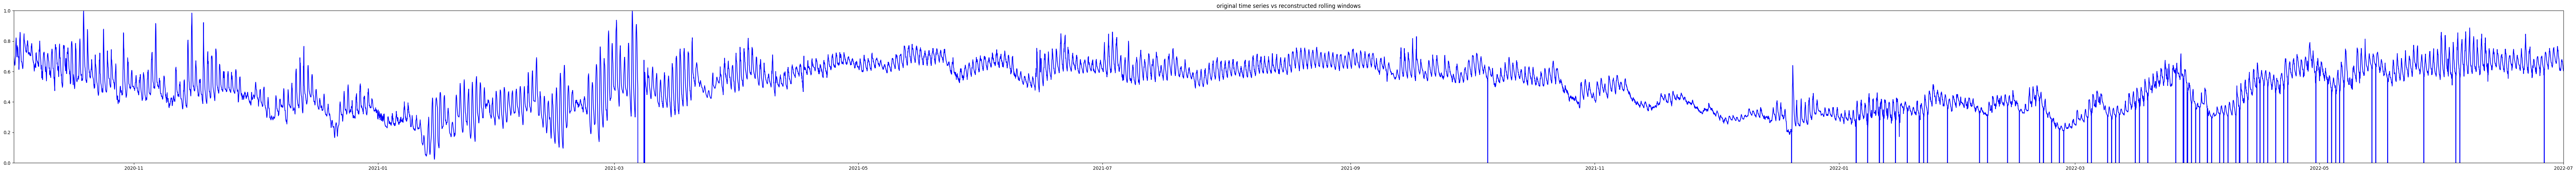

In [18]:
# plot the original time series and reconstructed segments

utils.plot_time_series(t, train, x_win=None, 
                       date_range=['2020-10-02', '2022-07-01'], value_range=[0, 1],
                       title='original time series vs reconstructed rolling windows')

## Generate Reconstructed Time Series

With a trained TadGAN model, we feed the original time series segments (over rolling windows) to the following components of the model:
1. **encoder $\rightarrow$ generator**, which produces **reconstructed versions** of the segments,
2. **input space critic**, which produces **critic scores** of the segments.



In [14]:
# generate reconstructed time series segments
x_win_recon, critic_scores = model.predict(x_win)

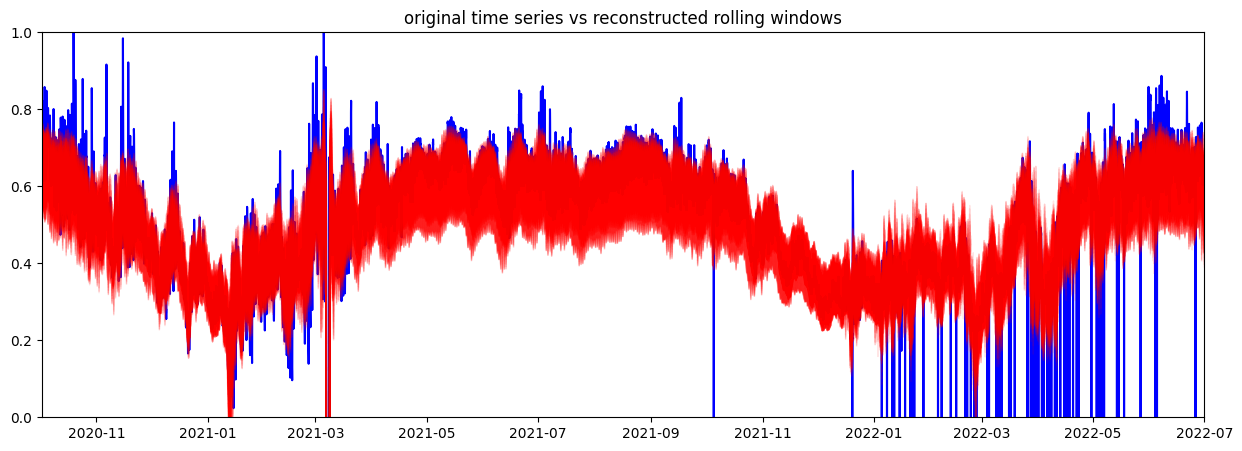

In [28]:
# plot the original time series and reconstructed segments

utils.plot_time_series(t, train, x_win=x_win_recon, 
                       date_range=['2020-10-02', '2022-07-01'], value_range=[0, 1],
                       title='original time series vs reconstructed rolling windows')

## Identify Anomalous Intervals

To identify anomalies in the original time series, we apply to the reconstructed segments a pipeline of post-processing steps, similar to those in [this tutorial](https://github.com/signals-dev/Orion/blob/master/notebooks/tulog/Tulog.ipynb). Briefly, these steps include:
- merge the reconstructed segments over rolling windows into a single reconstructed time series
- assign scores to individual time stamps based on reconstruction errors, as measured by local [DTW distances](https://en.wikipedia.org/wiki/Dynamic_time_warping) between the original and reconstructed time series
- transform the critic scores of the original segments over rolling windows into scores associated to individual time stamps
- combine the above two series of scores
- identify extreme values of the combined scores, from either the global or a local perspective

For further details, see documentation in the code.

In [19]:
# apply postprocessing pipeline to obtain anomalous intervals

params = {
    'recon_score_params': RECON_SCORE_PARAMS,
    'anomalous_seq_params': ANOMALOUS_SEQ_PARAMS
}

detected_intervals, _, _ = postprocessing.apply_pipeline(train, t, x_win_recon, critic_scores, **params)
detected_intervals = detected_intervals[['start', 'end']].to_numpy()

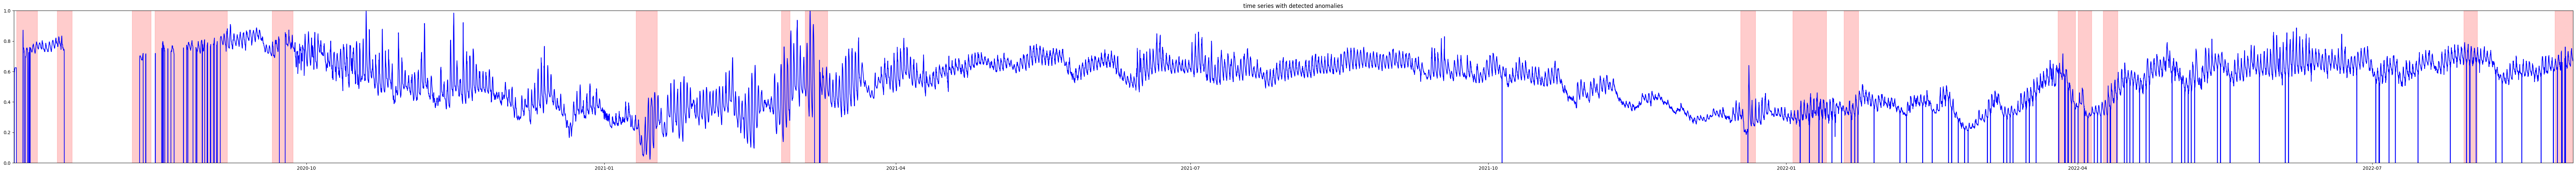

In [20]:
# plot time series with detected anomalies

utils.plot_time_series(t, train, detected_intervals=detected_intervals,
                       value_range=[0, 1], title='time series with detected anomalies')